#  Прогнозирование заказов такси

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Проверим на дубликаты, пропуски и преобразуем тип данных

In [5]:
data.duplicated().sum()

0

In [6]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [7]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [8]:
data = data.set_index('datetime')

In [9]:
print(data.index.is_monotonic)

True


Итак у нас монотонный временной ряд с шагом в 10 минут. Ресемплируем на 1 час

In [10]:
data = data.resample('1H').sum()

## Анализ

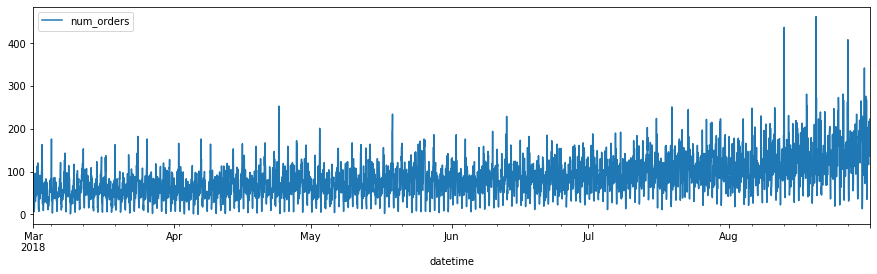

In [11]:
data.plot(figsize=(15,4))

Не очень информативно, однако видны существенные выбросы после авугста.

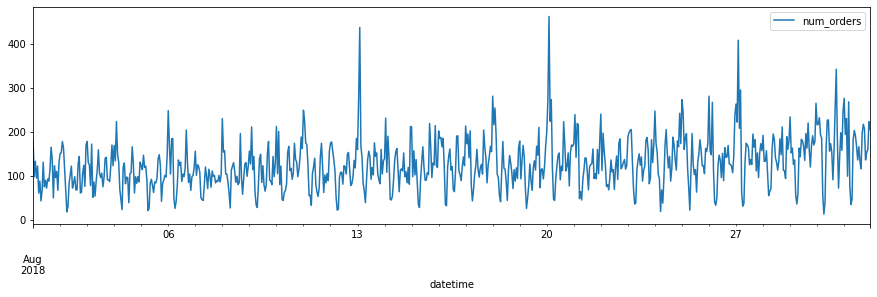

In [12]:
lol = data['2018-08':]
lol.plot(figsize=(15,4))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


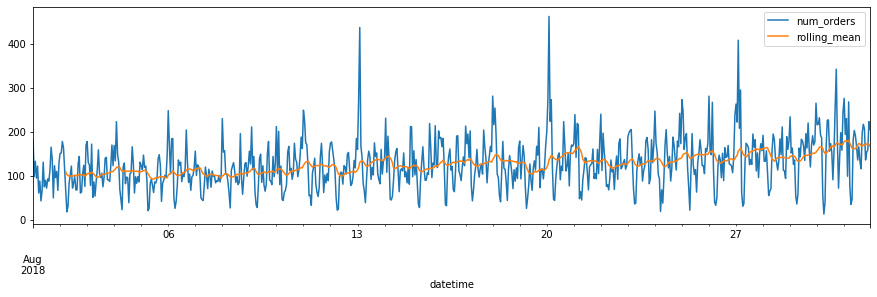

In [13]:
lol['rolling_mean'] = lol.rolling(30).mean() 
lol.plot(figsize=(15,4))

Посмотрим на тренд за август

In [14]:
lol = lol.drop(['rolling_mean'], axis=1)

In [15]:
decomposed_lol = seasonal_decompose(lol)

Text(0.5, 1.0, 'Trend')

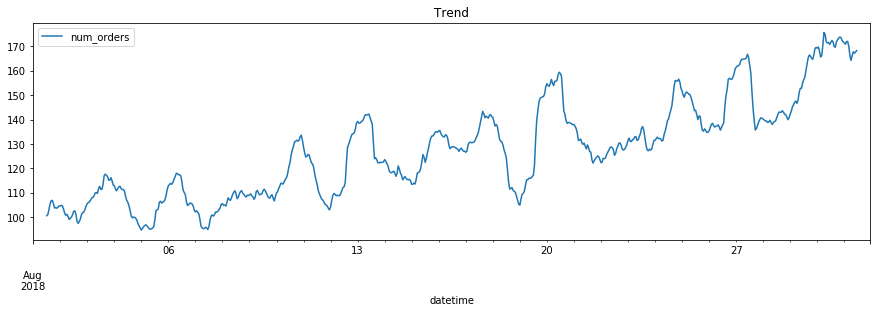

In [16]:
decomposed_lol.trend.plot(ax=plt.gca(), figsize=(15,4))
plt.title('Trend')


Итак, видим восходящий тренд с скачками в 3-4 дня. Восходящий тренд ясен! Пондемии не было, туризм развивался активно.
Что касается скачков, думаю это связано с чартерными рейсами. Они обычно летают пару раз в неделю.
Посмотрим весь датасет.

In [17]:
decomposed = seasonal_decompose(data)

Text(0.5, 1.0, 'Trend')

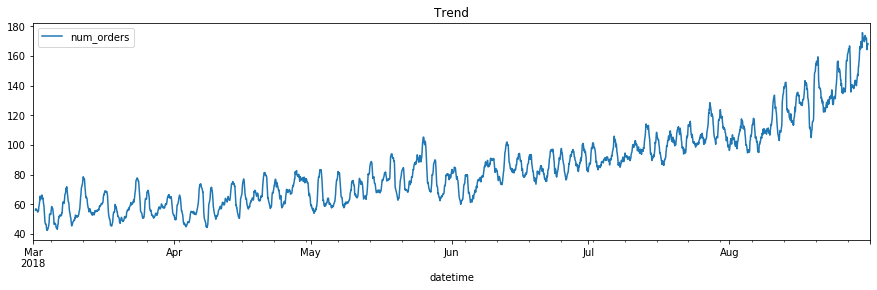

In [18]:
decomposed.trend.plot(ax=plt.gca(), figsize=(15,4))
plt.title('Trend')



Text(0.5, 1.0, 'Seasonality')

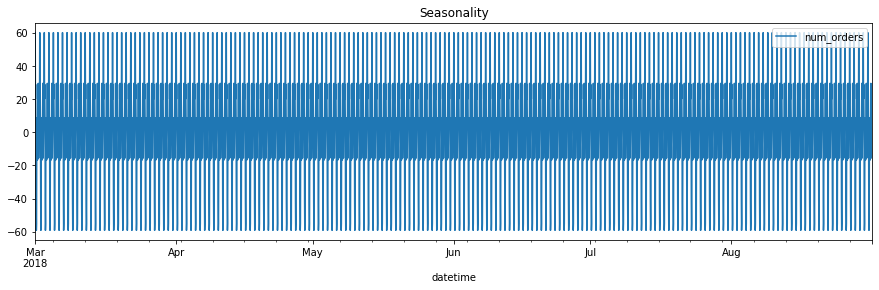

In [19]:
decomposed.seasonal.plot(ax=plt.gca(), figsize=(15,4)) 
plt.title('Seasonality')



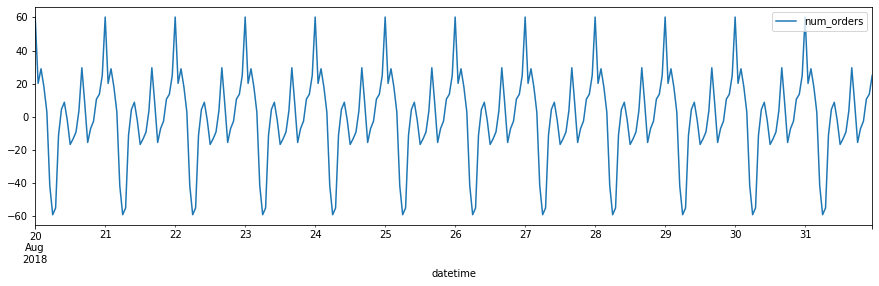

In [20]:
decomposed.seasonal['2018-08-20':].plot(ax=plt.gca(), figsize=(15,4)) 

Text(0.5, 1.0, 'Residuals')

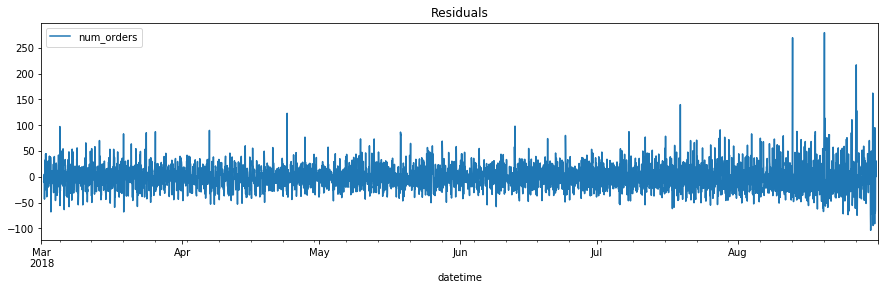

In [21]:
decomposed.resid.plot(ax=plt.gca(), figsize=(15,4))
plt.title('Residuals')


Видим стабильно восходящий тренд, сезонности нет, остатки не обьяснить

## Обучение

Создадим признаки: час, день, месяц, день недели, отстающие значения, скользящее среднее.

In [22]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [23]:
def make_features(df, max_lag, rolling_mean_size):
    new_df = df.copy()
    new_df['hour'] = new_df.index.hour
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_df['lag_{}'.format(lag)] = new_df['num_orders'].shift(lag)

    new_df['rolling_mean'] = new_df['num_orders'].shift().rolling(rolling_mean_size).mean() 
    return new_df
    

In [24]:
feat_data = make_features(data, 4, 4)

feat_data = feat_data.dropna()
feat_data.head(10)

,num_orders,hour,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 04:00:00,43,4,3,1,3,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,5,3,1,3,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,6,3,1,3,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,7,3,1,3,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,8,3,1,3,15.0,12.0,6.0,43.0,19.00
2018-03-01 09:00:00,69,9,3,1,3,34.0,15.0,12.0,6.0,16.75
2018-03-01 10:00:00,64,10,3,1,3,69.0,34.0,15.0,12.0,32.50
2018-03-01 11:00:00,96,11,3,1,3,64.0,69.0,34.0,15.0,45.50
2018-03-01 12:00:00,30,12,3,1,3,96.0,64.0,69.0,34.0,65.75


In [25]:
train, test = train_test_split(feat_data, shuffle=False, test_size=0.1)

In [26]:
train_features = train.drop(columns='num_orders')
train_target = train['num_orders']
test_features = test.drop(columns='num_orders')
test_target = test['num_orders']


#### LinearRegression

In [27]:
tscv_l = TimeSeriesSplit(n_splits = 3)

for train_index, test_index in tscv_l.split(train_features):
    cv_train_features_l, cv_test_features_l = train_features.iloc[train_index] \
                                        , train_features.iloc[test_index]
    cv_train_target_l, cv_test_target_l = train_target.iloc[train_index] \
                                    , train_target.iloc[test_index]
    
    
mod_l = LinearRegression()
mod_l.fit(cv_train_features_l, cv_train_target_l)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### DecisionTreeRegressor

In [28]:
mod_t = DecisionTreeRegressor()
param_search_t = {'max_depth' : [1, 15]}

tscv_t = TimeSeriesSplit(n_splits=3)
gsearch_t = GridSearchCV(estimator=mod_t, cv=tscv_t,
                        param_grid=param_search_t, scoring="neg_mean_absolute_error")
gsearch_t.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': [1, 15]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_e

#### RandomForestRegressor

In [29]:
mod_f = RandomForestRegressor()
param_search_f = {'max_depth' : [1, 20], 'n_estimators' : [10, 71, 10]}

tscv_f = TimeSeriesSplit(n_splits=3)
gsearch_f = GridSearchCV(estimator=mod_f, cv=tscv_f,
                        param_grid=param_search_f, scoring="neg_mean_absolute_error")
gsearch_f.fit(train_features, train_target)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=No

## Тестирование

In [30]:
pred_l = mod_l.predict(cv_test_features_l)
    
rsme_l = np.sqrt(mean_squared_error(pred_l, cv_test_target_l))


In [31]:
pred_t = gsearch_t.predict(test_features)
rsme_t = np.sqrt(mean_squared_error(pred_t, test_target))

In [33]:
pred_f = gsearch_f.predict(test_features)
rsme_f = np.sqrt(mean_squared_error(pred_f, test_target))

In [34]:
print("RMSE на древе решений:", rsme_t)
print("RMSE на линейной регресии:", rsme_l)
print("RMSE на случайном лесе:", rsme_f)

RMSE на древе решений: 54.27286833582391
RMSE на линейной регресии: 37.496617696019946
RMSE на случайном лесе: 46.368311307472545


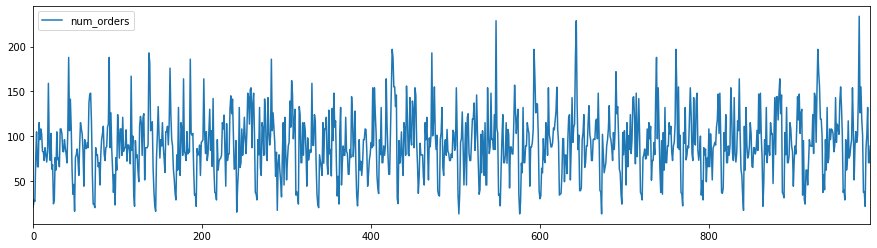

In [39]:
#print(pred_f)
lol1 = pd.DataFrame(data=pred_f, columns=["num_orders"])


lol1.plot(figsize=(15,4))

#### Вывод

Целевого показателя RMSE удалось добиться через модель дерева решений в регрессии, соответственно его и следует использовать.

В дата сете видим стабильно восходящий тернд заказа такси без сезонности, но с выбросами в мосент прилёта чартерных рейсов.